# Time dependent parameters

PyGOM may also be used with time dependent parameters.
Such situations commonly enter epidemic modelling if, for example, the rate of infection shows time dependence due to seasonal effects or interventions.
Let's consider an SIR model with periodic infectivity ($beta(t)$) and add in immune waning too (so we can witness multiple seasons):

$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\frac{\beta(t) SI}{N} + w R \\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \frac{\beta(t) SI}{N}- \gamma I \\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I - w R \\
\beta(t) &= \beta_0 \left(1+\delta \cos \left(\frac{2 \pi t}{P} \right) \right)
\end{aligned}$$

where $\beta_0$ is some baseline infection rate, $\delta$ is the magnitude of oscillations from the baseline ($-1<\delta<1$ so that $\beta>0$), $P$ is the oscillation period and $w$ is the waning rate.
PyGOM cannot handle the time dependence explicitly, instead we must define a dummy variable, $\tau$, to play the same role.
We thus append our set of equations with one extra:

$$\begin{aligned}
\frac{\mathrm{d} \tau}{\mathrm{d} t} &= 1
\end{aligned}$$

This takes the place of an extra ``state'' in our system, so we need to treat it as such by:

- Declaring it in our state list
- Including the equation above in our ode list
- Providing an initial condition (doesn't matter too much, but best set $\tau_0=0$ if $t_0=0$)

We must also provide the functional form of $\beta$.
It might be easiest to do so by including it as a `derived parameter`.

In [16]:
from pygom import SimulateOde, Transition, TransitionType
import matplotlib.pyplot as plt
import numpy as np

# Define SIR model
stateList = ['S', 'I', 'R', 'tau']                                    # now we have added tau to the states
paramList = ['gamma', 'N', 'beta0', 'delta', 'period', 'w']
derived_param = [('beta', 'beta0*(1+delta*cos(2*3.14*tau/period))')]  # beta (with tau instead of t)

odeList=[Transition(origin='S', equation='-beta*S*I/N + w*R', transition_type=TransitionType.ODE),
         Transition(origin='I', equation='beta*S*I/N - gamma*I', transition_type=TransitionType.ODE),
         Transition(origin='R', equation='gamma*I - w*R', transition_type=TransitionType.ODE),
         Transition(origin='tau', equation='1', transition_type=TransitionType.ODE)]  # d(tau)/dt = 1

# Set parameter values
gamma=0.25    # Recovery rate
n_pop=1e4     # Total population
beta0=0.3     # Baseline infectivity
period=365    # Period 1 year
delta=0.2     # beta varies between 0.8 and 1.2 times beta0
w=2/(365)     # timescale of immune waning of order 0.5 year

params=[('gamma', gamma),
        ('N', n_pop),
        ('beta0', beta0),
        ('delta', delta),
        ('period', period),
        ('w', w)]

# Initial conditions
i0=1
x0 = [n_pop-i0, i0, 0, 0]             # We specify tau(0)=0

# Time range and increments
tmax=10*365                           # run for 10 years
dt=0.1                                # timestep
n_timestep=int(tmax/dt)               # number of iterations
t = np.linspace(0, tmax, n_timestep)  # times at which solution will be evaluated

# Set up pygom object
ode = SimulateOde(stateList,
                  paramList,
                  ode=odeList,
                  derived_param=derived_param)

ode.initial_values = (x0, t[0])  # (initial state conditions, initial timepoint)
ode.parameters=params

Solve and plot

Text(0.5, 1.0, 'tau')

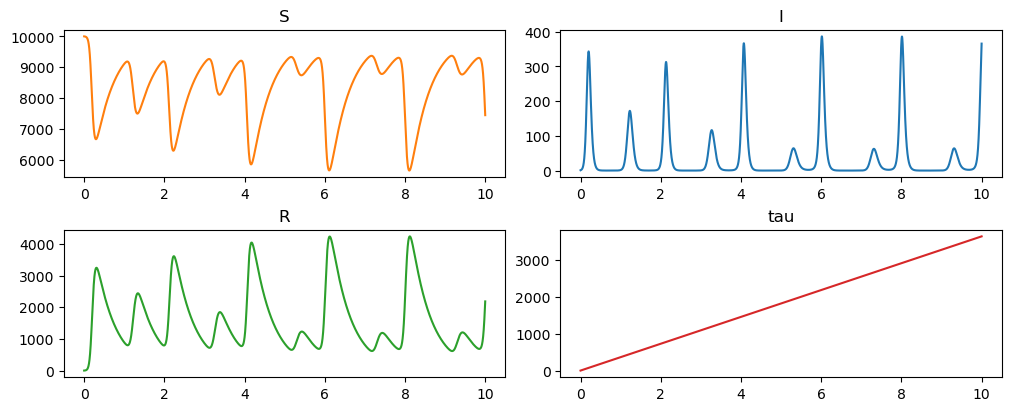

In [20]:
solution = ode.solve_determ(t[1::])

f, axarr = plt.subplots(2,2, layout='constrained', figsize=(10, 4))

axarr[0][0].plot(t/365, solution[:,0], color='C1')
axarr[0][1].plot(t/365, solution[:,1], color='C0')
axarr[1][0].plot(t/365, solution[:,2], color='C2')
axarr[1][1].plot(t/365, solution[:,3], color='C3')
axarr[0][0].set_title("S")
axarr[0][1].set_title("I")
axarr[1][0].set_title("R")
axarr[1][1].set_title("tau")

TODO: Figure out how to do this for a step function.